# Predicting Mortgage Delinquency Risk

You have been hired by a mortgage servicing firm (a company that buys mortgages and then collects mortgage payments from homeowners) to build a model to answer the question: 

**Given all available information about a newly issued mortgage, what is the likelihood that the mortgage will enter delinquency (the homeowner will be at least 30 days late on a mortgage payment) during the first two years of the mortgage?**

The servicer's hope, obviously, is to differentiate between mortgages to try and purchase (those that will be consistently paid) and mortgages they wish to avoid.

For this task, you have been given [REAL data on a sample of all US Standard single family home mortgages purchased or insured by Freddie Mac](https://www.freddiemac.com/research/datasets/sf-loanlevel-dataset) in a single calendar year along with payment data from that and two subsequent years.

## WARNING

**This assignment is substantially longer than the exercises you may be accustomed to if you were in IDS 720. Please start early!**


## Gradescope Autograding

Please follow [all standard guidance](https://www.practicaldatascience.org/ids720_specific/autograder_guidelines.html) for submitting this assignment to the Gradescope autograder, including storing your solutions in a dictionary called `results` and ensuring your notebook runs from the start to completion without any errors.

For this assignment, please name your file `exercise_passive_prediction.ipynb` before uploading.

You can check that you have answers for all questions in your `results` dictionary with this code:

```python
assert set(results.keys()) == {
    "ex2_merge_type",
    "ex5_num_mortgages",
    "ex5_share_delinquent",
    "ex7_num_obs",
    "ex11_predicted_delinquent",
    "ex11_share_delinquent_weighted",
    "ex13_optimal_threshold",
    "ex14_normalized_value",
    "ex15_num_obs",
    "ex15_share_delinquent",
    "ex16_final_return_pct",
    "ex16_normalized_value_2007",
}
```


### Submission Limits

Please remember that you are **only allowed THREE submissions to the autograder.** Your last submission (if you submit 3 or fewer times), or your third submission (if you submit more than 3 times) will determine your grade Submissions that error out will **not** count against this total.


### Good Notebook Practices

Please also review and follow all [Good Jupyter Notebook Practices](https://www.practicaldatascience.org/notebooks/PDS_not_yet_in_coursera/20_programming_concepts/writing_good_jupyter_notebooks.html) guidelines. They ARE grade relevant.

## Data Cleaning and Organization

Data for this exercise can be [found here](https://github.com/nickeubank/MIDS_Data/tree/master/mortgages/2004). This folder includes both the data to be used and documentation, though you can find [supplemental documentation here](https://www.freddiemac.com/research/datasets/sf-loanlevel-dataset).

The only modifications I've made to this data are:

- Subset to mortgages taken out for purchase of a property,
- With first payments due in the quarter of origination or the first quarter after origination (the vast majority of loans have first payments due the month after origination, so this just gets rid of some very weird mortgages).
- I have also excluded mortgages for which origination data is available but servicing data is not available in the two years following the year of origination.
- I also subset the data on servicing to the first 24 months after the mortgages first payment is due, so for each mortgage you will only have data on what happened in the first 24 months of its life.

However, post-subsetting I have done my best to convert the data back to the original format to make your experience working with the data as authentic as possible.

In [1]:
#YL
# import all packages

import warnings
import pandas as pd
import numpy as np
from patsy import dmatrices
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier #pip install scikit-learn
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


warnings.simplefilter(action="ignore", category=FutureWarning)
pd.set_option("mode.copy_on_write", True)

results = {}

### Exercise 1

Begin by loading both: 

- the mortgage origination file (`sample_orig_2004_standard_mortgages.txt.zip`). This *should* contain information on all mortgages issued in 2004, along with non-time varying features of these mortgages (the initial amount, the credit score of the applicant, etc.), and 
- the servicing data (`sample_svcg_2004_threeyears_standard_mortgages.txt.zip`). This contains monthly records of all recorded payments (or non-payments) for all mortgages issued in 2004 during the calendar years of 2004, 2005, and 2006. As noted above, this has also been subset to only include the first 24 months after the first payment was due (though Freddie Mac has some data cleanliness issues, so sometimes there will be less than 24 records covering that first 24 months).

So the autograder can see the data, be sure to load it directly from a URL (don't download and load from your own system).

Because this is **real** data, it has some issues (even beyond what I've cleaned above). While I generally love to leave students to work through this stuff, this is a long exercise, so here are a couple tips:

- The data is zip compressed. When you gives pandas a zip file that has only one thing in the zip archive, it will *usually* infer what's going on and decompress it without help. However, if the file name or URL you pass to pandas does not end in `.zip`, this automatic inference will fail and you will need to use the `compression` keyword to explicitly tell pandas the file is zip compressed.
- When you load the data, you will see it does not have column names. You will likely need to reference the documentation to figure out appropriate column names.
  - pandas will automatically treat the first row of a dataset as column names, not data. When working with a dataset that lacks column names, not only do you have to set the column names (so you know the meaning of each column), you also have to make sure pandas doesn't treat the first row as labels and not data (effectively dropping it).

In [2]:
col_mortgage = [
    "Credit Score",
    "First Payment Date",
    "First Time Homebuyer Flag",
    "Maturity Date",
    "Metropolitan Statistical Area (MSA) Or Metropolitan Division",
    "Mortgage Insurance Percentage (MI %)",
    "Number of Units",
    "Occupancy Status",
    "Original Combined Loan-to-Value (CLTV)",
    "Original Debt-to-Income (DTI) Ratio",
    "Original UPB",
    "Original Loan-to-Value (LTV)",
    "Original Interest Rate",
    "Channel",
    "Prepayment Penalty Mortgage (PPM) Flag",
    "Amortization Type (Formerly Product Type)",
    "Property State",
    "Property Type",
    "Postal Code",
    "Loan Sequence Number",
    "Loan Purpose",
    "Original Loan Term",
    "Number of Borrowers",
    "Seller Name",
    "Servicer Name",
    "Super Conforming Flag",
    "Pre-HARP Loan Sequence Number",
    "Program Indicator",
    "HARP Indicator",
    "Property Valuation Method",
    "Interest Only (I/O) Indicator",
    "Mortgage Insurance Cancellation Indicator",
]


db_mortage = pd.read_csv(
    "https://github.com/nickeubank/MIDS_Data/raw/refs/heads/master/mortgages/2004/sample_orig_2004_standard_mortgages.txt.zip",
    compression="zip",
    sep="|",
    header=None,
    names=col_mortgage,
    index_col=None,
)
print(db_mortage.shape)
db_mortage.head(2)

(17471, 32)


,Credit Score,First Payment Date,First Time Homebuyer Flag,Maturity Date,Metropolitan Statistical Area (MSA) Or Metropolitan Division,Mortgage Insurance Percentage (MI %),Number of Units,Occupancy Status,Original Combined Loan-to-Value (CLTV),Original Debt-to-Income (DTI) Ratio,...,Number of Borrowers,Seller Name,Servicer Name,Super Conforming Flag,Pre-HARP Loan Sequence Number,Program Indicator,HARP Indicator,Property Valuation Method,Interest Only (I/O) Indicator,Mortgage Insurance Cancellation Indicator
0,653,200403,Y,203402,20740.0,17,1,P,87,25,...,2,Other sellers,Other servicers,NaN,NaN,9,NaN,9,N,9
1,747,200403,N,203402,30700.0,0,2,I,70,34,...,1,Other sellers,Other servicers,NaN,NaN,9,NaN,9,N,9


In [3]:
col_servicing = [
    "Loan Sequence Number",
    "Monthly Reporting Period",
    "Current Actual UPB",
    "Current Loan Delinquency Status",
    "Loan Age",
    "Remaining Months to Legal Maturity",
    "Defect Settlement Date",
    "Modification Flag",
    "Zero Balance Code",
    "Zero Balance Effective Date",
    "Current Interest Rate",
    "Current Deferred UPB",
    "Due Date of Last Paid Installment (DDLPI)",
    "MI Recoveries",
    "Net Sales Proceeds",
    "Non MI Recoveries",
    "Expenses",
    "Legal Costs",
    "Maintenance and Preservation Costs",
    "Taxes and Insurance",
    "Miscellaneous Expenses",
    "Actual Loss Calculation",
    "Modification Cost",
    "Step Modification Flag",
    "Deferred Payment Plan",
    "Estimated Loan-to-Value (ELTV)",
    "Zero Balance Removal UPB",
    "Delinquent Accrued Interest",
    "Delinquency Due to Disaster",
    "Borrower Assistance Status Code",
    "Current Month Modification Cost",
    "Interest Bearing UPB",
]

db_servicing = pd.read_csv(
    "https://github.com/nickeubank/MIDS_Data/raw/refs/heads/master/mortgages/2004/sample_svcg_2004_threeyears_standard_mortgages.txt.zip",
    sep="|",
    header=None,
    names=col_servicing,
    index_col=None,
    dtype={
        "Current Loan Delinquency Status": str,
        "Modification Flag": str,
        "Step Modification Flag": str,
    },
)
print(db_servicing.shape)
db_servicing.head(2)

(379461, 32)


,Loan Sequence Number,Monthly Reporting Period,Current Actual UPB,Current Loan Delinquency Status,Loan Age,Remaining Months to Legal Maturity,Defect Settlement Date,Modification Flag,Zero Balance Code,Zero Balance Effective Date,...,Modification Cost,Step Modification Flag,Deferred Payment Plan,Estimated Loan-to-Value (ELTV),Zero Balance Removal UPB,Delinquent Accrued Interest,Delinquency Due to Disaster,Borrower Assistance Status Code,Current Month Modification Cost,Interest Bearing UPB
0,F04Q10000054,200403,126000.0,0,1,359,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,126000.0
1,F04Q10000054,200404,126000.0,0,2,358,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,126000.0


### Exercise 2

What is the unit of observation in `sample_orig_2004_standard_mortgages.txt` and in `sample_svcg_2004_threeyears_standard_mortgages.txt`?

>- The unit of observation in `sample_orig_2004_standard_mortgages.txt` is loans.
>- The unit of observation in `sample_svcg_2004_threeyears_standard_mortgages.txt` is loan-monthly payments

### Exercise 3

Merge your two datasets. Be sure to use the `validate` keyword argument in `merge`.

You will find some records in the origination files not in the servicing file. We need data from both files, so just do an `inner` join.

Assuming that you list the data associated with `sample_orig_2004_standard_mortgages.txt` first and `sample_svcg_2004_threeyears_standard_mortgages.txt` second, what keyword are you passing to `validate`? Store your answer as a string (use one of: `"1:1"`, `"m:1"`, `"1:m"`, `"m:m"`) in a dictionary called `results` under the key `ex2_merge_type`.

In [4]:
db_m = pd.merge(
    db_mortage,
    db_servicing,
    on="Loan Sequence Number",
    how="inner",
    indicator=True,
    validate="one_to_many",
)
print(db_m.shape)
db_m._merge.value_counts()

(379461, 64)


_merge
both          379461
left_only          0
right_only         0
Name: count, dtype: int64

In [5]:
results["ex2_merge_type"] = "1:m"

> When joining the data from sample_orig_2004 at the loan level with sample_svcg_2004 at the monthly payment unit of observation, we are facing a **Many-to-One** join.

### Exercise 4

For each unique mortgage in your dataset, create an indicator variable that takes on a value of 1 if, at any time during this period, the mortgage has been delinquent.

Delinquency status is stored in the variable `CURRENT LOAN DELINQUENCY STATUS`, and is coded as:

> CURRENT LOAN DELINQUENCY STATUS – A value corresponding to the number of days the borrower is delinquent, based on the due date of last paid installment (“DDLPI”) reported by servicers to Freddie Mac, and is calculated under the Mortgage Bankers Association (MBA) method.
If a loan has been acquired by REO, then the Current Loan Delinquency Status will reflect the value corresponding to that status (instead of the value corresponding to the number of days the borrower is delinquent).
>
> 0 = Current, or less than 30 days delinquent
> 
> 1 = 30-59 days delinquent
> 
> 2=60–89days delinquent
> 
> 3=90–119days delinquent
> 
> And so on...
> 
> RA = REO Acquisition


In [6]:
db_m["Indicator"] = (
    db_m.groupby("Loan Sequence Number")[
        "Current Loan Delinquency Status"]
    .transform(lambda x: (x != "0").any())
    .astype(int)
)
db_m.sample(2)

,Credit Score,First Payment Date,First Time Homebuyer Flag,Maturity Date,Metropolitan Statistical Area (MSA) Or Metropolitan Division,Mortgage Insurance Percentage (MI %),Number of Units,Occupancy Status,Original Combined Loan-to-Value (CLTV),Original Debt-to-Income (DTI) Ratio,...,Deferred Payment Plan,Estimated Loan-to-Value (ELTV),Zero Balance Removal UPB,Delinquent Accrued Interest,Delinquency Due to Disaster,Borrower Assistance Status Code,Current Month Modification Cost,Interest Bearing UPB,_merge,Indicator
260755,694,200411,Y,203410,17460.0,0,1,P,75,27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,194208.05,both,0
96837,767,200407,N,203406,40140.0,0,4,I,80,37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,421070.72,both,0


### Exercise 5

At this point, you should be able to drop all servicing variables reported on a monthly basis and just keep information about the original mortgage issuance (and still keep an indicator for whether the mortgage has ever been delinquent).

Store the final number of mortgages in your data under `ex5_num_mortgages` and the share (between 0 and 1) of mortgages that have been delinquent under `ex5_share_delinquent`. **Please round the share delinquent to 3 decimal places.**

In [7]:
# remove duplicate rows

db_m_filtered = db_m.drop_duplicates(subset="Loan Sequence Number")
len(db_m_filtered)
ex5_share_delinquent = db_m_filtered[
    db_m_filtered["Indicator"] == 1
    ].shape[0] / len(db_m_filtered)

In [8]:
# drop all servicing variables reported on a monthly basis

col_servicing2 = col_servicing.copy()

cols_to_remove = [
    "Monthly Reporting Period",
    "Current Actual UPB",
    "Current Loan Delinquency Status",
    "Loan Age",
    "Remaining Months to Legal Maturity",
    "Defect Settlement Date",
    "Modification Flag",
    "Zero Balance Code",
    "Zero Balance Effective Date",
    "Current Interest Rate",
    "Current Deferred UPB",
    "Due Date of Last Paid Installment (DDLPI)",
    "MI Recoveries",
    "Net Sales Proceeds",
    "Non MI Recoveries",
    "Expenses",
    "Legal Costs",
    "Maintenance and Preservation Costs",
    "Taxes and Insurance",
    "Miscellaneous Expenses",
    "Actual Loss Calculation",
    "Modification Cost",
    "Step Modification Flag",
    "Deferred Payment Plan",
    "Estimated Loan-to-Value (ELTV)",
    "Zero Balance Removal UPB",
    "Delinquent Accrued Interest",
    "Delinquency Due to Disaster",
    "Borrower Assistance Status Code",
    "Current Month Modification Cost",
    "Interest Bearing UPB",
    "_merge",
]


db_m_filtered = db_m_filtered.drop(columns=cols_to_remove)
db_m_filtered.shape

(17471, 33)

In [9]:
ex5_num_mortgages = len(db_m_filtered)
results["ex5_num_mortgages"] = ex5_num_mortgages
results["ex5_share_delinquent"] = round(ex5_share_delinquent, 3)

print(
    f"After eliminating all repeated mortgage rows based on the "
    f"Loan Sequence Number, the number of remaining observations in "
    f"the dataset is: {ex5_num_mortgages:,}."
)

print(
    f"The share of mortgages that have been delinquent is "
    f"{round(ex5_share_delinquent,3):,}."
)

After eliminating all repeated mortgage rows based on the Loan Sequence Number, the number of remaining observations in the dataset is: 17,471.
The share of mortgages that have been delinquent is 0.071.


>- After eliminating all repeated mortgage rows based on the Loan Sequence Number, the number of remaining observations in the dataset is: 17,471.
>- The share of mortgages that have been delinquent is 0.071.

## Modeling Delinquency Risk

Your data should now be relatively [tidy](https://vita.had.co.nz/papers/tidy-data.pdf), in the technical sense of the term. And that means it should be relatively straightforward for you to build a model that answers the question "Given the features of a newly originated mortgage, how likely is the mortgage holder to fall into delinquency within the first two years after origination?" to help your stakeholder decide which mortgages to purchase.

### Exercise 6

For your analysis, include the following variables: 

```
Credit Score
First Time Homebuyer Flag
Number of Units
Mortgage Insurance Percentage (MI %)
Occupancy Status
Original Debt-to-Income (DTI) Ratio
Original UPB
Original Loan-to-Value (LTV)
Original Interest Rate
Channel
Prepayment Penalty Mortgage (PPM) Flag
Amortization Type (Formerly Product Type)
Property State
Property Type
Original Loan Term
Number of Borrowers
Interest Only (I/O) Indicator
```

Be sure to clean these variables. When doing so, please treat missing data as missing (e.g., `np.nan`, not as a distinct category). You will probably want to consult the documentation on the data for guidance on missing values.


In [10]:
db_model = db_m_filtered[
    [
        "Loan Sequence Number",
        "Credit Score",
        "First Time Homebuyer Flag",
        "Number of Units",
        "Mortgage Insurance Percentage (MI %)",
        "Occupancy Status",
        "Original Debt-to-Income (DTI) Ratio",
        "Original UPB",
        "Original Loan-to-Value (LTV)",
        "Original Interest Rate",
        "Channel",
        "Prepayment Penalty Mortgage (PPM) Flag",
        "Amortization Type (Formerly Product Type)",
        "Property State",
        "Property Type",
        "Original Loan Term",
        "Number of Borrowers",
        "Interest Only (I/O) Indicator",
        "Indicator",
    ]
]
db_model.sample(2)

,Loan Sequence Number,Credit Score,First Time Homebuyer Flag,Number of Units,Mortgage Insurance Percentage (MI %),Occupancy Status,Original Debt-to-Income (DTI) Ratio,Original UPB,Original Loan-to-Value (LTV),Original Interest Rate,Channel,Prepayment Penalty Mortgage (PPM) Flag,Amortization Type (Formerly Product Type),Property State,Property Type,Original Loan Term,Number of Borrowers,Interest Only (I/O) Indicator,Indicator
231456,F04Q30214407,786,N,1,0,P,23,320000,67,5.875,T,N,FRM,AZ,PU,360,2,N,0
122505,F04Q20416812,680,N,1,0,P,38,326000,80,5.875,R,N,FRM,OH,PU,360,2,N,0


In [11]:
db_model["Credit Score"] = db_model["Credit Score"].replace(9999, np.nan)
db_model["First Time Homebuyer Flag"] = db_model[
    "First Time Homebuyer Flag"].replace(
    "9", np.nan
)
db_model["Mortgage Insurance Percentage (MI %)"] = db_model[
    "Mortgage Insurance Percentage (MI %)"
].replace(999, np.nan)
db_model["Number of Units"] = db_model["Number of Units"].replace(
    99, np.nan)
db_model["Occupancy Status"] = db_model["Occupancy Status"].replace(
    "9", np.nan)
db_model["Original Debt-to-Income (DTI) Ratio"] = db_model[
    "Original Debt-to-Income (DTI) Ratio"
].replace(999, np.nan)
db_model["Original Loan-to-Value (LTV)"] = db_model[
    "Original Loan-to-Value (LTV)"
].replace(999, np.nan)
db_model["Channel"] = db_model["Channel"].replace("9", np.nan)
db_model["Property Type"] = db_model["Property Type"].replace(
    "99", np.nan)
db_model["Number of Borrowers"] = db_model["Number of Borrowers"].replace(
    99, np.nan)

### Why Aren't We Using Metropolitan Statistical Area (MSA)?

Metropolitan Statistical Area (MSA) is what the US Census Bureau calls what most people would think of as a city. Durham *plus* Chapel Hill are considered a single MSA, for example.

So looking at this list, you may be wondering why we aren't using the MSA variable in the data. After all, real estate is all about location, location, location, right? 

Well, the problem is the data is too sparse — it's missing for a substantial number of observations, and more importantly there are lots of MSAs with only a couple of observations that are delinquent (about 40% of MSAs have less than 4 mortgages that are delinquent in their first two years). That's just too sparse for modelling — when coefficients are being estimated for those categories, they're bound to over-fit.

Put differently: would you be comfortable estimating the delinquency rate for, say, the city of Denver, CO with three or fewer delinquent observations? Of course not, but when you try and predict values to new data, that's precisely what you're doing — applying an estimate of delinquency from a few delinquent observations to any new observations in that MSA.

If you were working with longer time periods or the dataset with *all* Freddie Mac mortgages (not a sample), you could probably use MSA.

### Exercise 7

The next step in our analysis is to convert our categorical variables to one-hot-encodings and use `train_test_split` to split our data.

To ensure replicability, **before** you `train_test_split` your data, please sort your data by `Loan Sequence Number`. This will ensure when we split the data with a random seed below, everyone will get the same split and the autograder will function.

You may create your one-hot-encodings however you wish, but I'm a fan of the [patsy library's](https://patsy.readthedocs.io/en/latest/overview.html) `dmatrices` function.

**Hint:** You should end up with 8 categorical variables, including some binary flags and `Number_of_Borrowers`, `Number_of_Units` (which you could argue should be continuous, but I think are better treated as categorical).

**Hint 2:** To use `patsy`, you will probably need to make some changes to the names of your variables. To make your life easier, you may wish to use a little snippet like this:

```python
import re
mortgages_2004.columns = [re.sub(" ", "_", c) for c in mortgages_2004.columns]
mortgages_2004.columns = [re.sub("[%/()-]", "", c) for c in mortgages_2004.columns]
```

**Hint 3:** your final `X` matrix should have 76 columns, including intercept.

Store the number of observations in your final dataset in `ex7_num_obs`. 

In [12]:
db_model = db_model.sort_values(by="Loan Sequence Number")

formula = (
    'Q("Indicator")~Q("Credit Score") +'
    'C(Q("First Time Homebuyer Flag")) +'
    'C(Q("Number of Units")) + '
    'Q("Mortgage Insurance Percentage (MI %)") +'
    'C(Q("Occupancy Status")) + '
    'Q("Original Debt-to-Income (DTI) Ratio") + '
    'Q("Original UPB") + '
    'Q("Original Loan-to-Value (LTV)") + '
    'Q("Original Interest Rate") + '
    'C(Q("Channel")) + '
    'C(Q("Prepayment Penalty Mortgage (PPM) Flag")) + '
    'C(Q("Amortization Type (Formerly Product Type)")) + '
    'C(Q("Property State")) +'
    'C(Q("Property Type")) + '
    'Q("Original Loan Term") +'
    'C(Q("Number of Borrowers")) + '
    'C(Q("Interest Only (I/O) Indicator"))'
)
#TODO recently added - confirm the correct format
db_model["Number of Units"] = db_model["Number of Units"].astype(float)

y, X = dmatrices(formula, data=db_model, return_type="dataframe")

ex7_num_obs = X.shape[0]
results["ex7_num_obs"] = ex7_num_obs
print(
    f"After performing our one hot encoding and removing null elements, the number of observations in the dataset is {ex7_num_obs:,}."
)

After performing our one hot encoding and removing null elements, the number of observations in the dataset is 17,052.


> After performing our one hot encoding and removing null elements, the number of observations in the dataset is 17,052.

### Exercise 8

Use `train_test_split` from `sklearn.model_selection` to split the data. 

Before you do, Use `0.2` as the `test_size` and use `random_state=42`.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### Exercise 9

Now fit a `GradientBoostingClassifier` to the data (from `sklearn.ensemble`). Set `random_state=42` when instantiating your `GradientBoostingClassifier`.


In [14]:
gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_train, y_train.squeeze())

GradientBoostingClassifier(random_state=42)

### Exercise 10

Use the `predict` method and your test data to generate a confusion matrix. 

What problem do you see with the result? Round the share of observations predicted to be delinquent to three decimal places and store them under `ex10_predicted_delinquent` in `results`.

In [15]:
y_hat = gbc.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_hat)
conf_matrix

array([[3146,    9],
       [ 252,    4]])

In [16]:
db_model["Indicator"].value_counts()

Indicator
0    16229
1     1242
Name: count, dtype: int64

In [17]:
share_pred_1 = (y_hat == 1).mean()
results["ex10_predicted_delinquent"] = round(share_pred_1, 3)
print(results["ex10_predicted_delinquent"])

0.004


>- In this problem, we encounter imbalanced data, as the number of mortgages entering delinquency during the first two years is much less than number of mortgages not entering delinquency during the first two years.
>- This imbalance causes issues in our predictions, as we can see in our confusion matrix, where True Negatives dominate, while True Positives are underrepresented.
>- The model appears to lean towards classifying the majority of instances as negatives, which can be problematic, especially since we are interested in correctly identifying instances of delinquency.

### Exercise 11

With imbalanced data, it's not uncommon for classification algorithms to maximize performance by basically just predicting everything is the dominant class.

One way to help reduce this behavior is to re-weight the data so that each observation of the dominant class gets less weight and each observation in the minority class gets more. A common default approach is to weigh each class with the reciprocal of its share of the data (so if delinquencies were 5% of our observations, we would give each delinquent observation a weight of 1/0.05 = 20, and each non-delinquent observation a weight of 1/0.95 = 1.0526...).

To accomplish this, create an array with sample weights using this reciprocal rule for each observation and pass it to the `sample_weight` argument of `.fit()` and refit your model.

To help the autograder, please:

- Recalculate the share of observations that are delinquent and use the full calculated value to calculate weights, and
- Re-instantiate your `GradientBoostingClassifier` with `random_state=42`.

What share of observations are now predicted to be delinquent? Store the share under `ex11_share_delinquent_weighted` in `results`. **Round your answer to three decimal places.**

In [18]:
delinquency_share = y_train.mean()
majority_share   = 1.0 - delinquency_share

w_1 = 1.0 / delinquency_share
w_0 = 1.0 / majority_share

sample_weights = np.where(y_train.values.flatten() == 1, w_1, w_0)

gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_train, y_train.values.flatten(), sample_weight=sample_weights)

y_hat_weighted = gbc.predict(X_test)
frac_pred_delq_weighted = (y_hat_weighted == 1).mean()

results["ex11_predicted_delinquent"] =      round(frac_pred_delq_weighted, 3)
results["ex11_share_delinquent_weighted"] = round(frac_pred_delq_weighted, 3)


print(f"Predicted to be delinquent (weighted model) = {results['ex11_predicted_delinquent']}.")
print(f"Share predicted to be delinquent (weighted model) = {results['ex11_share_delinquent_weighted']}")



Predicted to be delinquent (weighted model) = 0.298.
Share predicted to be delinquent (weighted model) = 0.298


>The share of observations that are now predicted to be delinquent is 0.298.

### Exercise 12

As you can tell, these weights are obviously parameters than can be tuned, but for the moment let's stick with the results of our model fit with reciprocal weights.

A classification model like this will provide a default classification threshold, but we can also use `.predict_proba()` to get *probabilities* the model assigns to whether each observation is a `1`. This is helpful, because one thing we can do as data scientists is play with the probability threshold at which we call an observation a `1`. 

In other words, you can vary the threshold value `t` at which you say "for any observation with `.predict_proba()` above a value `t` is a 1, and any observation with a value below `t` is a 0." Then for each `t`, you will get a set of predicted classes for which you can calculate the resulting number of true and false positives and negatives.

(If you think in these terms, changing the sample weights we give the model will impact the orientation of the separating hyperplane the model creates to split the data; changing the classification threshold at which an observation is considered a `1` basically constitutes a simple shifting the hyperplane.)

Using the results of our `GradientBoostingClassifier` fit with reciprocal sample weights, get the predicted probabilities for each observation in our test data. 

Plot the share of observations classified as delinquent against classification thresholds from 0 to 1.

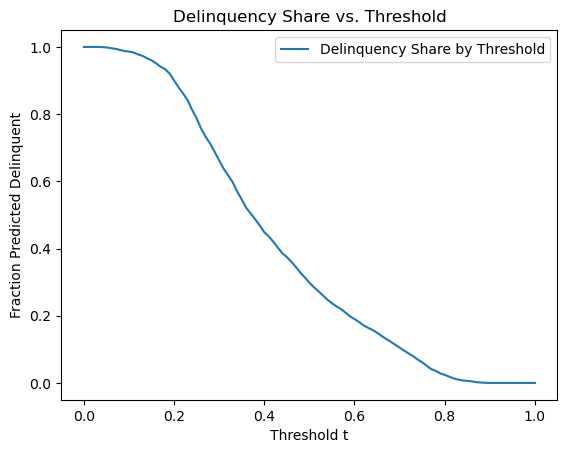

In [19]:
thresholds = np.linspace(0, 1, 101)
y_probs = gbc.predict_proba(X_test)[:, 1]
y_pred_t = (y_probs >= 0.5).astype(int)
share_delinquent_t = y_pred_t.mean()

share_del_t_list = []

for t in thresholds:
    y_pred_t = (y_probs >= t).astype(int)
    share_t = y_pred_t.mean()
    share_del_t_list.append(share_t)

import matplotlib.pyplot as plt

plt.plot(thresholds, share_del_t_list, label
         ='Delinquency Share by Threshold')
plt.xlabel('Threshold t')
plt.ylabel('Fraction Predicted Delinquent')
plt.title('Delinquency Share vs. Threshold')
plt.legend()
plt.show()


### Exercise 13

From this visualization, you should be able to see that by changing our classification threshold, we can change the share of mortgages predicted to be delinquent (e.g., classified as dangerous to buy). If we *really* wanted to avoid risk, we could use a threshold like 0.2, and our client would basically not buy any mortgages. Or we could choose a threshold like 0.8 and our client would buy almost all the mortgages available!

So what threshold *should* we use? 

Assume that, for your client, a good mortgage has a value of 1. (We can think of this as a normalization of any actual financial value). A delinquent mortgage the client has purchased has a value of -20 — that is, if the client bought 21 mortgages and 1 turned out to be delinquent, they would break even. 

A good mortgage they fail to purchase they think is costing them about -0.05 times the value of a good mortgage. We can think of this as the "opportunity cost" of failing to buy a good mortgage and instead having to put their money somewhere else with a lower return.

This is the same as saying, when we think about our classification matrix, that the relative value of an observation in each cell is (normalized to the value of a True Negative (a safe mortgage predicted to be safe) being 1):

- True Positive: 0 (a mortgage correctly predicted to be delinquent our stakeholder didn't buy).
- True Negative: 1 (a mortgage correctly predicted to be safe our stakeholder did buy).
- False Negative: -20 (a mortgage incorrectly predicted to be safe our stakeholder did buy and that turned out to be delinquent).
- False Positive: -0.05 (a mortgage incorrectly predicted to be delinquent our stakeholder didn't buy but which turned out to be safe).

Again, without tuning our `sample_weights` (which you might do in a real analysis), what classification threshold would you choose? 

Do a grid search with ~1,000 grid steps. Find the threshold with the highest expected value and store it under the key `"ex13_optimal_threshold"`. **Round your answer to the nearest half tenth (0.05).** 

I know, I know — this is a _very_ weird rounding, but grid search is lumpy, so people will likely get slightly different answers, and rounding to two decimals isn't quite stable enough for an autograder. So your answer should be something like `0.15`, `0.20`, `0.25`, `0.30`, `0.35`, `0.40`, `0.45`, etc.

Please also plot your threshold against value calculations.

In [20]:
prob_test = gbc.predict_proba(X_test)[:, 1]

threshold_grid = np.linspace(0, 1, 1000)

best_threshold = None
best_value = -9999.0
best_threshold_raw = None

for t in threshold_grid:
    y_pred = (prob_test >= t).astype(int)
    
    tp = np.sum((y_test.values.flatten() == 1) & (y_pred == 1))
    tn = np.sum((y_test.values.flatten() == 0) & (y_pred == 0))
    fp = np.sum((y_test.values.flatten() == 0) & (y_pred == 1))
    fn = np.sum((y_test.values.flatten() == 1) & (y_pred == 0))
    
    total_value = (0 * tp) + (1.0 * tn) + (-0.05 * fp) + (-20.0 * fn)
    
    avg_value = total_value / len(y_test)
    
    if avg_value > best_value:
        best_value = avg_value
        best_threshold_raw = t

rounded_t = round(round(best_threshold_raw / 0.05) * 0.05, 2)

results["ex13_optimal_threshold"] = rounded_t
print("Raw best threshold =", best_threshold_raw)
print("Rounded to nearest 0.05 =", results["ex13_optimal_threshold"])

Raw best threshold = 0.35435435435435436
Rounded to nearest 0.05 = 0.35


### Exercise 14

What is the value your customer will get at that (rounded-to-nearest-half-tenth) threshold per mortgage available (i.e., assume a True Negative yields a value of 1, calculate the value generated by your test data at your rounded optimal threshold, then normalize by the number of observations in the test data). Store this normalized value in `ex14_normalized_value`. **Round your answer to two decimal places.**

In [21]:
chosen_threshold = results["ex13_optimal_threshold"]

y_pred_final = (prob_test >= chosen_threshold).astype(int)

tp = np.sum((y_test.values.flatten() == 1) & (y_pred_final == 1))
tn = np.sum((y_test.values.flatten() == 0) & (y_pred_final == 0))
fp = np.sum((y_test.values.flatten() == 0) & (y_pred_final == 1))
fn = np.sum((y_test.values.flatten() == 1) & (y_pred_final == 0))

total_value = (0 * tp) + (1.0 * tn) + (-0.05 * fp) + (-20.0 * fn)
avg_value = total_value / len(y_test)

results["ex14_normalized_value"] = round(avg_value, 2)
print("Value per mortgage at chosen threshold:", results["ex14_normalized_value"])

Value per mortgage at chosen threshold: 0.15


## Now To The Future

Most of the time, at least as students, we never get to see how well our predictions do. We fit our models on our training data, then evaluate their performance against our test data, and because we're evaluating our model against data it hadn't seen during training, we act as if we're really evaluating how well our predictions would fair if deployed in the real world.

But our mortgage data is from 2004, and as you may have noticed, 2004 was actually a while ago, which means we can now see how the model we trained on the first 24 months of payments on mortgages that originated in 2004 would do if we actually deployed it. To have our 24 months of payments, of course, the soonest we could have done the analysis above would have been in late 2006. So let's assume that your boss *immediately* deploys your model and starts buying up all the mortgages your model says should be purchased starting on January 1st 2007 and continued through December 31st 2007. 

Would you have gotten the average value per mortgage your model predicted? 



### Exercise 15

In this [folder](https://github.com/nickeubank/MIDS_Data/tree/master/mortgages/2007) you will find data on mortgages originated in 2007 along with servicing data from 2007, 2008, and 2009.

Please:

- load this data (again, from a URL to help the autograder). 
- clean up your data as you did the data from the earlier period, 
- use patsy to prepare the data so you can use the model **from above** (the model that used the reciprocal weights on data from mortgages originating in 2004) with this data. 

In other words, we're using the model you trained on 2004 data to predict credit risk for these new mortgages. We're doing this to simulate what you would do if you were to actually put the model you fit in Exercise 11 "into production" to model the risk of new mortgages. So you won't use the `.fit()` method again, just the `.predict()` method with the new data.


**Warning**: Because you are asking sklearn to use a model trained on one dataset to predict values using predictors from a second dataset, any difference in the structure of the second dataset will cause problems. For example, if `num_of_units` is an integer in the 2007 data when you try and run your predictions, but it was a float in the 2004 data, patsy will give the columns slightly different names and you'll get an error like this:

```python
ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- C(num_of_units)[T.2]
- C(num_of_units)[T.3]
- C(num_of_units)[T.4]
Feature names seen at fit time, yet now missing:
- C(num_of_units)[T.2.0]
- C(num_of_units)[T.3.0]
- C(num_of_units)[T.4.0]
```

This can be corrected by ensuring that `num_of_units` is of the same type when you run `dmatrices` for both datasets. 

Your final X matrix should still have 76 columns. As sanity checks, store the final number of observations in your data after using patsy to make a design matrix in `"ex15_num_obs"` and the share of mortgages in your design matrix that are actually delinquent in `"ex15_share_delinquent"`. **Round the share delinquent to three decimal places.**

**Hint:** The 2007 delinquency rate should be higher than the 2004 delinquency rate for reasons you can probably figure out if you google it. Something happened with mortgages between 2007 and 2009...

In [22]:
# Load 2007 origination
col_mortgage = [
    "Credit Score",
    "First Payment Date",
    "First Time Homebuyer Flag",
    "Maturity Date",
    "Metropolitan Statistical Area (MSA) Or Metropolitan Division",
    "Mortgage Insurance Percentage (MI %)",
    "Number of Units",
    "Occupancy Status",
    "Original Combined Loan-to-Value (CLTV)",
    "Original Debt-to-Income (DTI) Ratio",
    "Original UPB",
    "Original Loan-to-Value (LTV)",
    "Original Interest Rate",
    "Channel",
    "Prepayment Penalty Mortgage (PPM) Flag",
    "Amortization Type (Formerly Product Type)",
    "Property State",
    "Property Type",
    "Postal Code",
    "Loan Sequence Number",
    "Loan Purpose",
    "Original Loan Term",
    "Number of Borrowers",
    "Seller Name",
    "Servicer Name",
    "Super Conforming Flag",
    "Pre-HARP Loan Sequence Number",
    "Program Indicator",
    "HARP Indicator",
    "Property Valuation Method",
    "Interest Only (I/O) Indicator",
    "Mortgage Insurance Cancellation Indicator",
]

db_mort_2007 = pd.read_csv(
    "https://github.com/nickeubank/MIDS_Data/raw/refs/heads/master/"
    "mortgages/2007/sample_orig_2007_standard_mortgages.txt.zip",
    compression="zip",
    sep="|",
    header=None,
    names=col_mortgage,
    index_col=None,
)

print(db_mort_2007.shape)
db_mort_2007.head(2)

(22542, 32)


,Credit Score,First Payment Date,First Time Homebuyer Flag,Maturity Date,Metropolitan Statistical Area (MSA) Or Metropolitan Division,Mortgage Insurance Percentage (MI %),Number of Units,Occupancy Status,Original Combined Loan-to-Value (CLTV),Original Debt-to-Income (DTI) Ratio,...,Number of Borrowers,Seller Name,Servicer Name,Super Conforming Flag,Pre-HARP Loan Sequence Number,Program Indicator,HARP Indicator,Property Valuation Method,Interest Only (I/O) Indicator,Mortgage Insurance Cancellation Indicator
0,769,200702,N,203701,24220.0,0,1,P,90,38,...,2,Other sellers,Other servicers,NaN,NaN,9,NaN,9,N,9
1,598,200703,N,203702,NaN,0,1,P,90,45,...,2,Other sellers,Other servicers,NaN,NaN,9,NaN,9,N,9


In [23]:
# Load 2007 servicing
col_servicing = [
    "Loan Sequence Number",
    "Monthly Reporting Period",
    "Current Actual UPB",
    "Current Loan Delinquency Status",
    "Loan Age",
    "Remaining Months to Legal Maturity",
    "Defect Settlement Date",
    "Modification Flag",
    "Zero Balance Code",
    "Zero Balance Effective Date",
    "Current Interest Rate",
    "Current Deferred UPB",
    "Due Date of Last Paid Installment (DDLPI)",
    "MI Recoveries",
    "Net Sales Proceeds",
    "Non MI Recoveries",
    "Expenses",
    "Legal Costs",
    "Maintenance and Preservation Costs",
    "Taxes and Insurance",
    "Miscellaneous Expenses",
    "Actual Loss Calculation",
    "Modification Cost",
    "Step Modification Flag",
    "Deferred Payment Plan",
    "Estimated Loan-to-Value (ELTV)",
    "Zero Balance Removal UPB",
    "Delinquent Accrued Interest",
    "Delinquency Due to Disaster",
    "Borrower Assistance Status Code",
    "Current Month Modification Cost",
    "Interest Bearing UPB",
]

db_svcg_2007 = pd.read_csv(
    "https://github.com/nickeubank/MIDS_Data/raw/refs/heads/master/"
    "mortgages/2007/sample_svcg_2007_threeyears_standard_mortgages.txt.zip",
    sep="|",
    header=None,
    names=col_servicing,
    dtype={
        "Current Loan Delinquency Status": str,
        "Modification Flag": str,
        "Step Modification Flag": str,
    }
)

print(db_svcg_2007.shape)
db_svcg_2007.head(2)

(481871, 32)


,Loan Sequence Number,Monthly Reporting Period,Current Actual UPB,Current Loan Delinquency Status,Loan Age,Remaining Months to Legal Maturity,Defect Settlement Date,Modification Flag,Zero Balance Code,Zero Balance Effective Date,...,Modification Cost,Step Modification Flag,Deferred Payment Plan,Estimated Loan-to-Value (ELTV),Zero Balance Removal UPB,Delinquent Accrued Interest,Delinquency Due to Disaster,Borrower Assistance Status Code,Current Month Modification Cost,Interest Bearing UPB
0,F07Q10000023,200702,195000.0,0,1,359,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,195000.0
1,F07Q10000023,200703,195000.0,0,2,358,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,195000.0


In [24]:
# Merge (inner), create delinquency indicator.
db_2007 = pd.merge(
    db_mort_2007,
    db_svcg_2007,
    on="Loan Sequence Number",
    how="inner",
)
db_2007["Indicator"] = (
    db_2007.groupby("Loan Sequence Number")[
        "Current Loan Delinquency Status"]
    .transform(lambda x: (x != "0").any())
    .astype(int)
)

print(db_2007.shape)
db_2007.head(2)

(481871, 64)


,Credit Score,First Payment Date,First Time Homebuyer Flag,Maturity Date,Metropolitan Statistical Area (MSA) Or Metropolitan Division,Mortgage Insurance Percentage (MI %),Number of Units,Occupancy Status,Original Combined Loan-to-Value (CLTV),Original Debt-to-Income (DTI) Ratio,...,Step Modification Flag,Deferred Payment Plan,Estimated Loan-to-Value (ELTV),Zero Balance Removal UPB,Delinquent Accrued Interest,Delinquency Due to Disaster,Borrower Assistance Status Code,Current Month Modification Cost,Interest Bearing UPB,Indicator
0,769,200702,N,203701,24220.0,0,1,P,90,38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,195000.0,0
1,769,200702,N,203701,24220.0,0,1,P,90,38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,195000.0,0


In [25]:
# Drop duplicates at the loan level, keep the same key columns
db_2007 = db_2007.drop_duplicates(subset="Loan Sequence Number")
db_2007.shape

(22542, 64)

In [26]:
db_2007["Credit Score"] = db_2007["Credit Score"].replace(9999, np.nan)
db_2007["First Time Homebuyer Flag"] = db_2007[
    "First Time Homebuyer Flag"].replace(
    "9", np.nan
)
db_2007["Mortgage Insurance Percentage (MI %)"] = db_2007[
    "Mortgage Insurance Percentage (MI %)"
].replace(999, np.nan)
db_2007["Number of Units"] = db_2007["Number of Units"].replace(
    99, np.nan)
db_2007["Occupancy Status"] = db_2007["Occupancy Status"].replace(
    "9", np.nan)
db_2007["Original Debt-to-Income (DTI) Ratio"] = db_2007[
    "Original Debt-to-Income (DTI) Ratio"
].replace(999, np.nan)
db_2007["Original Loan-to-Value (LTV)"] = db_2007[
    "Original Loan-to-Value (LTV)"
].replace(999, np.nan)
db_2007["Channel"] = db_2007["Channel"].replace("9", np.nan)
db_2007["Property Type"] = db_2007["Property Type"].replace(
    "99", np.nan)
db_2007["Number of Borrowers"] = db_2007["Number of Borrowers"].replace(
    99, np.nan)

In [27]:
db_2007_model = db_2007[
    [
        "Loan Sequence Number",
        "Credit Score",
        "First Time Homebuyer Flag",
        "Number of Units",
        "Mortgage Insurance Percentage (MI %)",
        "Occupancy Status",
        "Original Debt-to-Income (DTI) Ratio",
        "Original UPB",
        "Original Loan-to-Value (LTV)",
        "Original Interest Rate",
        "Channel",
        "Prepayment Penalty Mortgage (PPM) Flag",
        "Amortization Type (Formerly Product Type)",
        "Property State",
        "Property Type",
        "Original Loan Term",
        "Number of Borrowers",
        "Interest Only (I/O) Indicator",
        "Indicator",
    ]
]
print(db_2007_model.shape)
db_2007_model.head(2)

(22542, 19)


,Loan Sequence Number,Credit Score,First Time Homebuyer Flag,Number of Units,Mortgage Insurance Percentage (MI %),Occupancy Status,Original Debt-to-Income (DTI) Ratio,Original UPB,Original Loan-to-Value (LTV),Original Interest Rate,Channel,Prepayment Penalty Mortgage (PPM) Flag,Amortization Type (Formerly Product Type),Property State,Property Type,Original Loan Term,Number of Borrowers,Interest Only (I/O) Indicator,Indicator
0,F07Q10000023,769.0,N,1,0,P,38.0,195000,80,6.125,R,N,FRM,ND,SF,360,2.0,N,0
24,F07Q10000059,598.0,N,1,0,P,45.0,136000,80,6.000,R,N,FRM,ND,SF,360,2.0,N,0


In [28]:
import re

#excluding this portion since it was not used in 2004 dataset
#db_2007_model.columns = [re.sub(" ", "_", c) for c in
#                         db_2007_model.columns]
#db_2007_model.columns = [re.sub("[%/()\-]", "", c) for c in
#                         db_2007_model.columns]

# same formula you used for 2004
# (If you removed "-1" previously, be consistent here as well.)

#had to remove the starting Q
formula_2007 = (
    'Indicator~Q("Credit Score") +'
    'C(Q("First Time Homebuyer Flag")) +'
    'C(Q("Number of Units")) + '
    'Q("Mortgage Insurance Percentage (MI %)") +'
    'C(Q("Occupancy Status")) + '
    'Q("Original Debt-to-Income (DTI) Ratio") + '
    'Q("Original UPB") + '
    'Q("Original Loan-to-Value (LTV)") + '
    'Q("Original Interest Rate") + '
    'C(Q("Channel")) + '
    'C(Q("Prepayment Penalty Mortgage (PPM) Flag")) + '
    'C(Q("Amortization Type (Formerly Product Type)")) + '
    'C(Q("Property State")) +'
    'C(Q("Property Type")) + '
    'Q("Original Loan Term") +'
    'C(Q("Number of Borrowers")) + '
    'C(Q("Interest Only (I/O) Indicator"))'
)

#TODO recently added- force the unit
db_2007_model["Number of Units"] = db_2007_model["Number of Units"].astype(float)


y_2007, X_2007 = dmatrices(formula_2007, data=db_2007_model,
                           return_type="dataframe")

# 6) final number of observations:
results["ex15_num_obs"] = X_2007.shape[0]

# 7) actual fraction delinquent
frac_del_2007 = y_2007["Indicator"].mean()
results["ex15_share_delinquent"] = round(frac_del_2007, 3)

print("2007 final #obs:", results["ex15_num_obs"])
print("2007 share delinquent:", results["ex15_share_delinquent"])


2007 final #obs: 21972
2007 share delinquent: 0.11


### Exercise 16




Had your stakeholder purchased all the mortgages originating in 2007 using your model trained on 2004 mortgages, what would the average normalized value of those mortgages be?

Store your result under the key `"ex16_normalized_value_2007"`. **Round your answer to 2 decimal places.**

Calculate the actual return your model provided as a percentage of the predicted return (e.g., `100 * results["ex16_normalized_value_2007"] / results["ex14_normalized_value"]`, so 1 is one percent, 100 is 100 percent). 

To be clear, you should do this calculation with the *rounded* values you stored in `results` (again, for the autograder — in general you should never round until the end of calculations, but we're trying to smooth little differences).

Store this result as `"ex16_final_return_pct"`. **Round this calculated percentage one decimal place.**


In [29]:
chosen_threshold_13 = results["ex13_optimal_threshold"]
prob_2007 = gbc.predict_proba(X_2007)[:, 1]

y_pred_2007 = (prob_2007 >= chosen_threshold_13).astype(int)

y_true_2007 = y_2007.values.flatten()

tp_07 = np.sum((y_true_2007 == 1) & (y_pred_2007 == 1))
tn_07 = np.sum((y_true_2007 == 0) & (y_pred_2007 == 0))
fp_07 = np.sum((y_true_2007 == 0) & (y_pred_2007 == 1))
fn_07 = np.sum((y_true_2007 == 1) & (y_pred_2007 == 0))

total_value_2007 = (0 * tp_07) + (1.0 * tn_07) + (-0.05 * fp_07)
+ (-20.0 * fn_07)
avg_value_2007   = total_value_2007 / len(y_true_2007)

results["ex16_normalized_value_2007"] = round(avg_value_2007, 2)

# Compare to ex14_normalized_value from your 2004 test:
predicted_2004_value = results["ex14_normalized_value"]  # (already stored, 2 decimals)

ratio_percent = 100.0 * results[
    "ex16_normalized_value_2007"] / predicted_2004_value
results["ex16_final_return_pct"] = round(ratio_percent, 1)

print("Normalized value in 2007 data:", results[
    "ex16_normalized_value_2007"])
print("Ratio (pct) of 2004 expected performance:", results[
    "ex16_final_return_pct"], "%")


Normalized value in 2007 data: 0.38
Ratio (pct) of 2004 expected performance: 253.3 %


### Exercise 17

How did the performance of your model against your test data (from 2004) compare to your model's actual performance in later years (the 2007 data)? What lesson from our class readings does this illustrate, and how does it relate to internal and external validity?

The question is worth several points, and is meant to be the place where you reflect on why I made you do all this. Your answer should not be a couple sentences.

>When we tested on the 2004 hold‑out set, the model’s performance looked decent based on the cost function. However, mortgages originated in 2007 turned out to have much higher delinquency rates, and the average value of the model’s recommended purchases was dramatically lower than the test predictions. This is a prime example of external validity failure or distribution shift: the environment changed (i.e., the lead‑up to the 2008 financial crisis), so a model trained on 2004 data failed to generalize to 2007. It also illustrates the lesson from our readings that good test scores on one dataset do not guarantee good real‑world performance if conditions or distributions shift.

In [30]:
print("results keys:", results.keys())


results keys: dict_keys(['ex2_merge_type', 'ex5_num_mortgages', 'ex5_share_delinquent', 'ex7_num_obs', 'ex10_predicted_delinquent', 'ex11_predicted_delinquent', 'ex11_share_delinquent_weighted', 'ex13_optimal_threshold', 'ex14_normalized_value', 'ex15_num_obs', 'ex15_share_delinquent', 'ex16_normalized_value_2007', 'ex16_final_return_pct'])


In [31]:
#TODO adding to try and remove the extra key item 
del results["ex10_predicted_delinquent"]


assert set(results.keys()) == {
    "ex2_merge_type",
    "ex5_num_mortgages",
    "ex5_share_delinquent",
    "ex7_num_obs",
    "ex11_predicted_delinquent",
    "ex11_share_delinquent_weighted",
    "ex13_optimal_threshold",
    "ex14_normalized_value",
    "ex15_num_obs",
    "ex15_share_delinquent",
    "ex16_final_return_pct",
    "ex16_normalized_value_2007",
}


In [32]:
for key, value in results.items():
    print(value)

1:m
17471
0.071
17052
0.298
0.298
0.35
0.15
21972
0.11
0.38
253.3
